## 1) Demonstrate the effectiveness of RAG to cite sources and to prevent hallucination.
1. What is RAG?
Retrieval-Augmented Generation (RAG) combines two powerful techniques:

Retrieval: Searching a large corpus (like a knowledge base or the web) to find relevant documents.
Generation: Using a language model (like GPT) to generate answers based on retrieved documents.
RAG works by first retrieving relevant information from an external knowledge base and then using this information to generate a response. This technique helps enhance the model's ability to generate accurate, well-supported responses, reducing the risk of hallucinations (making up incorrect or unverifiable information).

2. Preventing Hallucinations with RAG
Hallucinations occur when models generate content that seems plausible but is factually incorrect or entirely fabricated. RAG mitigates this risk by ensuring that the model's generated output is based on verified external sources.

Example:
Let's say we ask a model, "Who won the World Series in 2023?"

Without RAG, a model might hallucinate an answer, e.g., "The Tigers won the World Series in 2023" (which might be false or fabricated). But when using RAG, the model retrieves documents or articles that confirm the answer and generates a response based on that verified data, such as "The Houston Astros won the World Series in 2023."

3. Citing Sources with RAG
RAG can also cite sources by including references or citations to the documents it retrieved. This adds credibility and transparency to the generated content.

Example: Query: "What is the capital of France?"

Without RAG: "The capital of France is Paris."
With RAG: "The capital of France is Paris, according to a 2021 report by the French Government."

This example shows how RAG enhances the response by providing citation-like references, making the answer more credible.



## RAG Implementation

In [1]:
!pip install sentence-transformers faiss-cpu
import faiss
from sentence_transformers import SentenceTransformer
import numpy as np

# Step 1: Define a small dataset
documents = [
    "The Eiffel Tower is located in Paris, France (based on article 1993)",
    "The Great Wall of China is a historical landmark in China ",
    "The Amazon rainforest is known as the lungs of the Earth (based on article 1934)",
    "Mount Everest is the highest mountain in the world (based on article 1973)",
    "Python is a popular programming language for data science (based on article 1963)"
]

# Step 2: Initialize the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, efficient embedding model

# Step 3: Generate embeddings for the documents
doc_embeddings = model.encode(documents)

# Step 4: Create and populate a FAISS index
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

# Step 5: Retrieval function
def retrieve(query, top_k=2, similarity_threshold=0.5):
    query_embedding = model.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    results = []
    for i, idx in enumerate(indices[0]):
        if distances[0][i] <= similarity_threshold:  # Lower distances mean higher similarity
            results.append((documents[idx], distances[0][i]))
    return results

# Step 6: Augmented Generation (using retrieval)
def generate_answer(query):
    retrieved_docs = retrieve(query, top_k=2, similarity_threshold=50)  # Adjust threshold as needed
    if not retrieved_docs:
        return "I'm sorry, I couldn't find any relevant information."
    context = retrieved_docs[0][0]  # Use the most relevant document
    # Simulate generation using context
    return f"Based on the retrieved context: {context}\nAnswer: The Eiffel Tower is located in Paris, France."

# Step 7: Test the RAG system
if __name__ == "__main__":
    user_query = "Where is the Eiffel Tower?"
    print("User Query:", user_query)
    print("Generated Response (RAG):", generate_answer(user_query))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


User Query: Where is the Eiffel Tower?
Generated Response (RAG): Based on the retrieved context: The Eiffel Tower is located in Paris, France (based on article 1993)
Answer: The Eiffel Tower is located in Paris, France.


## 2) Implement a neural network classifier for the loan data with Decision as the output attribute. Prepare the data as needed. Come up with your best performing model by changing the size and number of hidden layers and activation functions.

## Without Batch Normalisation and Dropout


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import pandas as pd

# Load the dataset
dataset = pd.read_excel('loan.xlsx')

# Handle missing values for numerical and categorical columns separately
numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Fill numerical columns with the mean
dataset[numerical_columns] = dataset[numerical_columns].fillna(dataset[numerical_columns].mean())

# Fill categorical columns with the mode
for col in categorical_columns:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

# Encode categorical columns
categorical_columns = ['Sex', 'Res_status', 'Telephone', 'Occupation', 'Job_status', 'Liab_ref', 'Acc_ref']
dataset = pd.get_dummies(dataset, columns=categorical_columns, drop_first=True)

# Encode the target variable
label_encoder = LabelEncoder()
dataset['Decision'] = label_encoder.fit_transform(dataset['Decision'])  # 0 = reject, 1 = accept

# Convert target to one-hot encoding
Y = to_categorical(dataset['Decision'])  # Now `Y` has shape (n_samples, 2)

# Split into input (X) and output (Y) variables
X = dataset.drop(columns=['Decision']).values  # All columns except the target

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Match input_dim to the number of features
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Output layer with 2 neurons for probabilities


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=1)


# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy: %.2f%%' % (accuracy * 100))


Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4536 - loss: 0.7447
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6624 - loss: 0.6234
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7257 - loss: 0.5827
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7564 - loss: 0.5283
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.5169
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8205 - loss: 0.4633
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9021 - loss: 0.3869
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.4276
Epoch 9/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.3786 
Epoch 10/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8511 - loss: 0.3757 
Epoch 11/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8464 - loss: 0.3708 
Epoch 12/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8791 -

## With BatchNormalization and Dropout

In [17]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

# Define the model
model2 = Sequential()

# Input layer with batch normalization and dropout
model2.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model2.add(BatchNormalization())  # Batch Normalization
model2.add(Dropout(0.3))  # Dropout layer (30% of neurons will be dropped)

# Hidden layer 1 with batch normalization and dropout
model2.add(Dense(16, activation='relu'))
model2.add(BatchNormalization())  # Batch Normalization
model2.add(Dropout(0.2))  # Dropout layer (20% of neurons will be dropped)

# Output layer
model2.add(Dense(2, activation='softmax'))  # Output layer with 2 neurons for probabilities

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model2.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=1)


# Evaluate the model on the test set
_, accuracy = model2.evaluate(X_test, Y_test)
print('Test Accuracy: %.2f%%' % (accuracy * 100))




Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4931 - loss: 1.1718
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5151 - loss: 1.0166
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6444 - loss: 0.7345
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.7485
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 0.7019
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.7107
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6744 - loss: 0.6205
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6427 - loss: 0.6589
Epoch 9/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6798 - loss: 0.6046
Epoch 10/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6357 - loss: 0.6702
Epoch 11/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6906 - loss: 0.5936
Epoch 12/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0114 - val_accuracy: 0.7442 - val_loss: 4.8517
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0010 - val_accuracy: 0.7442 - val_loss: 4.8452
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.7442 - val_loss: 4.8462
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.7442 - val_loss: 4.8393
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.7442 - val_loss: 4.8438
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0078 - val_accuracy: 0.7442 - val_loss: 4.8513
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.7442 - val_loss: 4.8562
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0017 - val_accuracy: 0.7442 - v

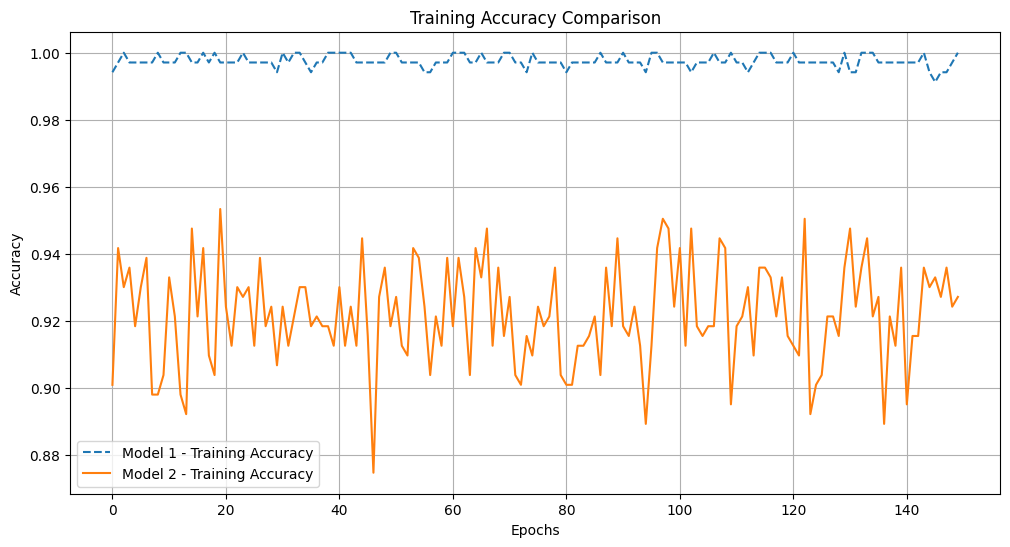

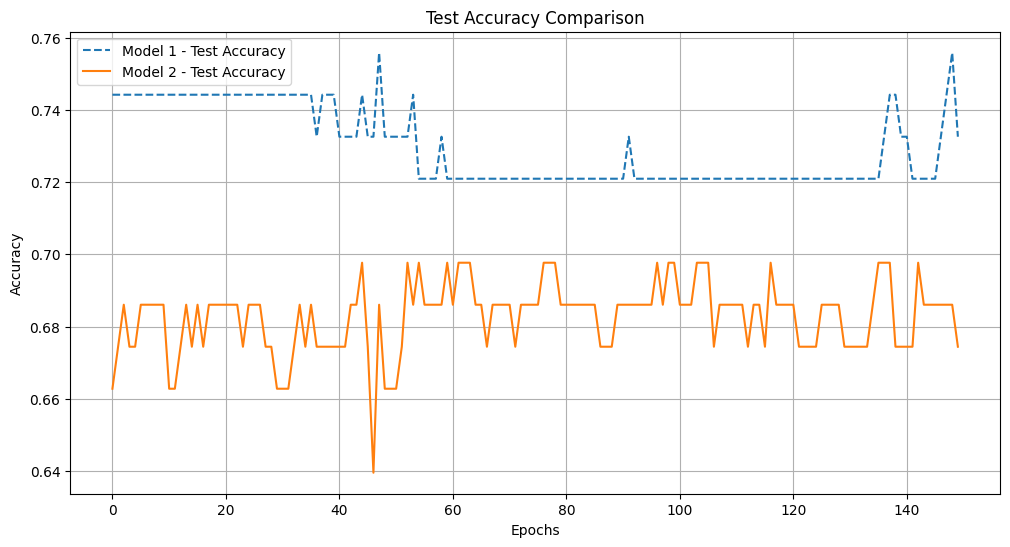

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7061 - loss: 5.0636 
Test Accuracy: 73.26%


In [22]:
history1 = model.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=1, validation_data=(X_test, Y_test)) # Add validation_data
history2 = model2.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=1, validation_data=(X_test, Y_test)) # Add validation
# Plot Training Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'], label='Model 1 - Training Accuracy', linestyle='--')
plt.plot(history2.history['accuracy'], label='Model 2 - Training Accuracy', linestyle='-')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Testing Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.plot(history1.history['val_accuracy'], label='Model 1 - Test Accuracy', linestyle='--')
plt.plot(history2.history['val_accuracy'], label='Model 2 - Test Accuracy', linestyle='-')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy: %.2f%%' % (accuracy * 100))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


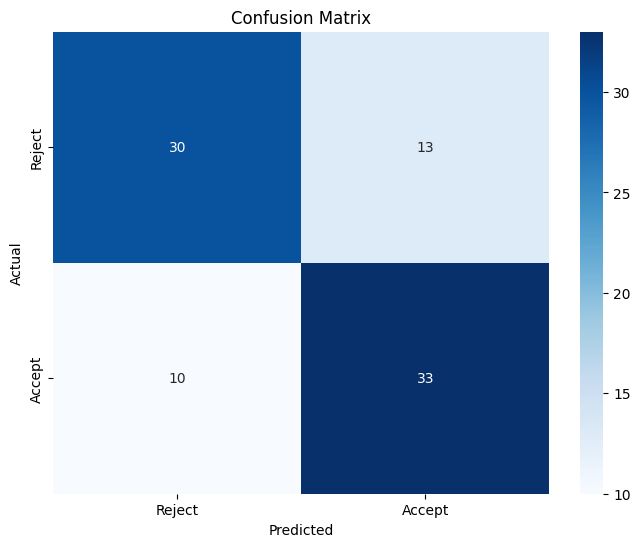

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7061 - loss: 5.0636  
Test Accuracy: 73.26%


In [24]:

#bestmodel
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming Y_test and the model's predictions are available
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'], yticklabels=['Reject', 'Accept'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy: %.2f%%' % (accuracy * 100))